In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as scp
import matplotlib.cm as cmx
from mssm.models import *

## Data structure

In [2]:
# Import some simulated data
dat = pd.read_csv("./data/IRGAMM/sim_dat.csv")

# mssm requires that the data-type for variables used as factors is 'O'=object
dat = dat.astype({'series': 'O',
                  'cond':'O',
                  'sub':'O',
                  'series':'O'})

# Load rts for every individual series - these do not match the length of
# the corresponding trial but indicate the sample at which a response was given
# (at which time-point the trial was over). The corresponding trial data has more
# rows in dat because we need to record for longer to capture the time delay in the
# measured signal y.
series_end = np.load("./data/IRGAMM/trial_ends.npy")


In [3]:
# So this should be true - a RT for every unique series!
print(len(series_end) == len(np.unique(dat["series"])))

True


In [4]:
dat.head()

,y,time,series,cond,sub,true_states
0,-7.721047,0,0,a,0,0
1,-4.271240,20,0,a,0,0
2,-10.902110,40,0,a,0,1
3,-9.770285,60,0,a,0,1
4,-7.807955,80,0,a,0,1


### About the data:

- The dependent variable can contain NAs, which will be taken care of. No NAs should be present in any of the predictor columns!
- We need an identifier of individual series. In this dataframe that is the variable 'series'. Usually a series is an individual trial - but if there are multiple conditions and the same trial values are used accross conditions the series identifier is actually the interaction of condition and trial.
- The column holding the time variable should be in ms.
- The dataframe should be ordered according to series, time: the ordered (increasing) time-series corresponding to the first series should make up the first n rows. The ordered time-series corresponding to the next series should make up the next k rows, and so on. More specifically, what matters is that individual series are making up a time-ordered sub-block of dat. So you could also have a dataframe that starts with a series labeled 0, then a series labeled 115, then a series labeled X. As long as the ordered time-series from series 0 is not interrupted by rows corresponding to any other series it will be fine.

In [5]:
# To make sure the last point is met - we can call:
dat = dat.sort_values(['series', 'time'], ascending=[True, True])

In [6]:
dat.head()

,y,time,series,cond,sub,true_states
0,-7.721047,0,0,a,0,0
1,-4.271240,20,0,a,0,0
2,-10.902110,40,0,a,0,1
3,-9.770285,60,0,a,0,1
4,-7.807955,80,0,a,0,1


# Model setup

1) Setup a formula for the impulse responses and the state dependent duration distributions.
2) Decide whether some impulse responses should be fixed at a specific sample or not.
3) Fit the model.

## Defining the model

In [7]:
# 1) Setup the Pformula:
# The PFormula holds the sojourn time distributions - these will estimate a distribution describing the typical duration of every state.
# Hence, n_j PTerms need to be provided - one for each state, reflecting the distribution that should be estimated for each state. You can provide the same distribution for every state
# or different distributions for different states (any continuous distribution implemented by scipy; see https://docs.scipy.org/doc/scipy/reference/stats.html). Here we assume that the durations of
# each state are distributed according to a gamma distribution. Thus we pass 'scp.stats.gamma' as the first argument to every PTerm. The second argument should get a disctionary with (distribution-specific) mandatory initial parameters.
# The scp.stats.gamma distribution must be provided with an 'a' parameter (see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html#scipy.stats.gamma). Hence we provide that one. We also
# provide a starting estimate for the scale parameter. The third argument can take a disctionary with arguments passed to the maximization step for the distribution parameters (when the model parameters are updated).
# We assume that the 'a' parameter should be fixed at 2 (see; Anderson et al., 2016) and the location parameter should be fixed to 0 (since durations can take on only values in [1,inf] we do not need to shift the support).
# You can read up on which arguments can be passed to the maximization process here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.fit.html#scipy.stats.rv_continuous.fit.
# Finally we provide a 'split_by' argument to tell the model to estimate separate duration distribution parameters per level of the factor cond.
pformula = PFormula([PTerm(scp.stats.gamma,{"a":2,"scale":15},{"fa":2,"floc":0},split_by="cond"),
                     PTerm(scp.stats.gamma,{"a":2,"scale":15},{"fa":2,"floc":0},split_by="cond"),
                     PTerm(scp.stats.gamma,{"a":2,"scale":15},{"fa":2,"floc":0},split_by="cond"),
                     PTerm(scp.stats.gamma,{"a":2,"scale":15},{"fa":2,"floc":0},split_by="cond"),
                     PTerm(scp.stats.gamma,{"a":2,"scale":15},{"fa":2,"floc":0},split_by="cond")])

# 2) Setup the formula:
# The Formula relates the impulse response functions and any other regression terms to be estimated to the variable of interest (specified via lhs).
# You always need to specify n_j-1 impulse respones, where n_j is the number of stages you are assuming. Impulse response functions are specified via irf().
# In the simplest model we only pass the 'time' variable to the list of variables argument for each irf(). The second argument passed to the irf() tells us
# which event the impulse response is connected to. It should run from 0 to n_j-1! The third 'by' argument tells us that we want to estimate separate impulse response functions
# for every level of the factor cond. The mandatory basis key-word arguments that need to be provided are 'max_c','min_c', and 'convolve'.
# 'max_c' should be set to the duration (in ms) of recording after a response was given (e.g., often a mask is displayed after a response is given for  X ms. max_c should be set to X).
# 'min_c' should be set to the moment of trial/stimulus onset.
# 'convolve' is necessary to ensure that a delayed response will be estimated.
# In this simulated data-set the 'y' variable was recorded for rt + 2500 ms, so max_c = 2500. For this formula we also add a random offset term to be estimated for every series - accounting for
# baseline differences from zero between series.
formula = Formula(lhs("y"),
                  [irf(["time"],0,nk=15,by="cond",basis_kwargs=[{"max_c":2500,"min_c":0,"convolve":True}]),
                   irf(["time"],1,nk=15,by="cond",basis_kwargs=[{"max_c":2500,"min_c":0,"convolve":True}]),
                   irf(["time"],2,nk=15,by="cond",basis_kwargs=[{"max_c":2500,"min_c":0,"convolve":True}]),
                   irf(["time"],3,nk=15,by="cond",basis_kwargs=[{"max_c":2500,"min_c":0,"convolve":True}]),
                   ri("series")],
                   data=dat,
                   series_id="series",
                   p_formula=pformula)

# 3) Setup fix. Fix should be of structure [[int,int] for fixation] or None. None means that no impulse response has an onset fixed at a given sample. If we want the first impulse to have a fixed onset at the first sample
# we need to set fix [[0,0]]. If you want to fix the last impulse response at the sample at which the response was given, you can set fix=[[3,-1]]. If you want to fix both the first and the last response, you can set
# fix = [[0,0],[3,-1]].
fix = None

# Now all we have to do is to define the model with the objects we just created. We also need to pass a family (Gaussian() is the obvious choice for continuous y, but you can check .src.exp_fam.py for other options.).
# We can also pass a number > 1 to cpus to tell the model to use more cores for estimation. Calling the line below will prompt a warning, that there are some NA in the 'y' column.
# This is just FYI and will be taken into account during fitting.
model = sMsIRGAMM(formula,Gaussian(),series_end,fix,cpus=8)

/Users/joshmac/Documents/repos/mssm/src/mssm/src/python/formula.py:1106: UserWarning: 3003 y values (9.32%) are NA.
  warnings.warn(f"{data.shape[0] - data[NAs_flat].shape[0]} {self.get_lhs().variable} values ({round((data.shape[0] - data[NAs_flat].shape[0]) / data.shape[0] * 100,ndigits=2)}%) are NA.")
/Users/joshmac/opt/anaconda3/envs/mssm_test/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


### Fitting the model

We can now fit the model. Depending on the number of series in the data, the complexity of the formula, and the number of cores available this can take anywhere from 5 min to **multiple days**.

In [8]:
llk_hist,states_flat,states = model.fit(t0=0.25,maxiter_outer=10)

Fitting - Conv.: 8.67e+02: 100%|██████████| 10/10 [00:45<00:00,  4.54s/it]


## Visualization

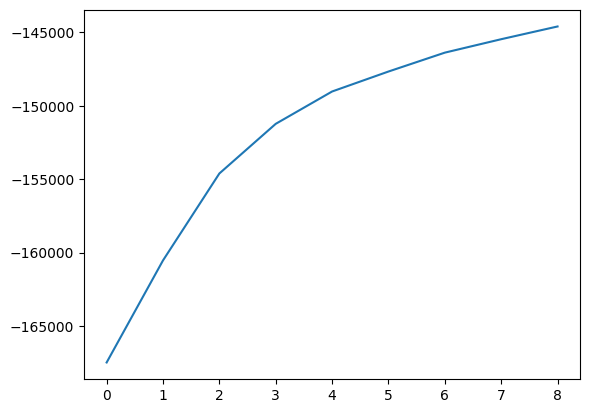

In [9]:
# Convergence
plt.plot(llk_hist)
plt.show()

In [10]:
# We can get the recovered parameters with this function!
coef,sigma = model.get_pars()

In [11]:
# coef contains for every column in the model matrix the associated weight
print(coef[0:20])

[ 14.90774359  26.95683622  46.9323211   69.44668797  88.3970737
  94.26457969  86.42397188  72.57140414  58.74875663  48.4501695
  42.00204752  37.49593336  32.28190406  23.21687264  18.9982684
  -4.80560413 -15.54176456 -23.18688152 -23.02657343 -16.66387919]


### Impulse responses

We can now look at the impulse responses recovered by the model. Remember, the sum of those is assumed to reveal the observed time-course of the signal (without the noise). We estimated separate impulse responses per condition so we can plot those separately. Also, since the onset of the impulse responses (marking a new stage) differed across trials we can plot the responses fixed to the estimated onsets for different trials to get a feeling for how the onset of the responses differs accross trials.

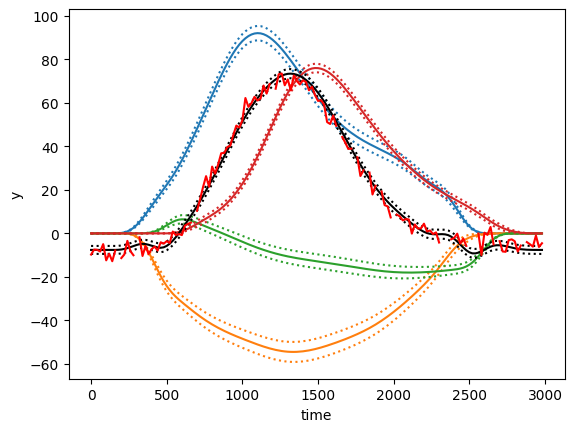

In [12]:
nc = 10
colors = [cmx.tab20(x) for x in np.linspace(0.0,min(0.1*nc,1.0),nc)]

s = 30 # series to look at

for si in range(4):
    # Set up some new data for prediction
    time_pred = np.arange(0,3000,20)
    new_dat = pd.DataFrame({"time":time_pred,
                            "cond":[np.unique(dat["cond"][dat["series"] == s])[0] for _ in range(len(time_pred))], # cond depends on s - change s to look at different conditions!
                            "series":[s for _ in range(len(time_pred))]})
    
    # Make prediction using only individual impulse responses.
    pred,_,b = model.predict([states[s]],[si],new_dat,ci=True,alpha=0.05)
    plt.plot(time_pred,pred,color=colors[si])
    plt.plot(time_pred,pred+b,color=colors[si], linestyle='dotted')
    plt.plot(time_pred,pred-b,color=colors[si], linestyle='dotted')

# Additive prediction = sum over all impulse responses = recovered signal.
pred,_,b = model.predict([states[s]],None,new_dat,ci=True,alpha=0.05)
plt.plot(time_pred,pred,color='black')
plt.plot(time_pred,pred+b,color='black', linestyle='dotted')
plt.plot(time_pred,pred-b,color='black', linestyle='dotted')

# Plot observed series.
plt.plot(dat["time"][dat["series"] == s],
         dat["y"][dat["series"] == s],color='red')

plt.xlabel("time")
plt.ylabel("y")
plt.show()

### Latent States

We can also look at the state transition sequences recovered for individual series.

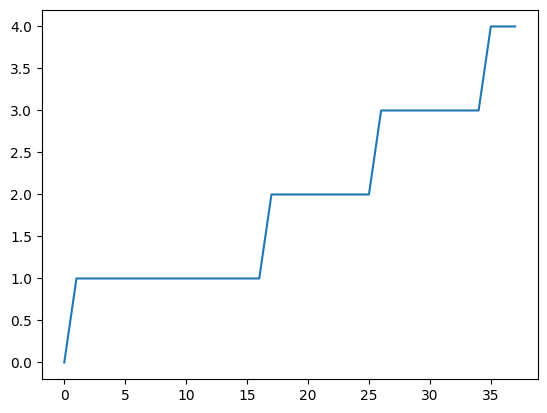

In [13]:
for s in [0]:
    plt.plot(states_flat[s])
    plt.show()

The duration of every state depends on the sojourn time distributions. We parameterized those with Gamma distributions. Initially, we set the a parameter to 2 and the scale parameter to 15. We can check how these parameters were updated!

[[2.         0.         1.66494845]
 [2.         0.         2.59708738]]


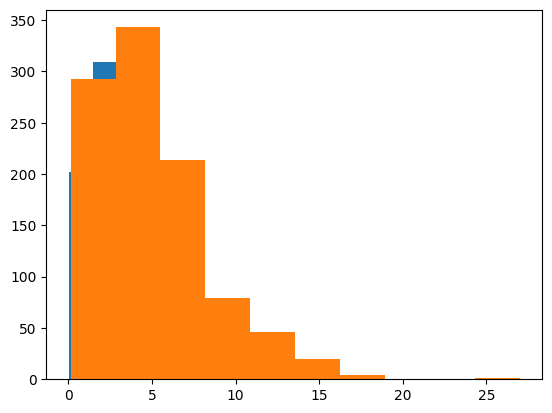

[[2.         0.         2.07731959]
 [2.         0.         4.24757282]]


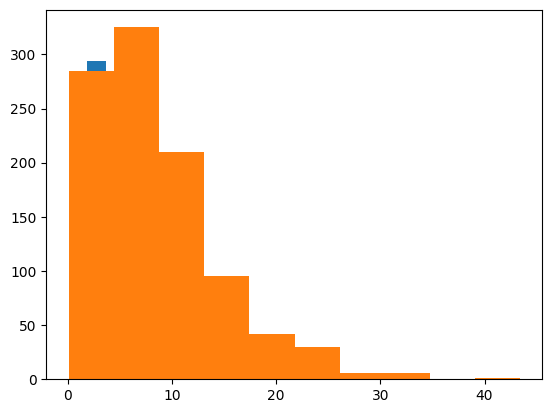

[[2.         0.         2.78350515]
 [2.         0.         5.99514563]]


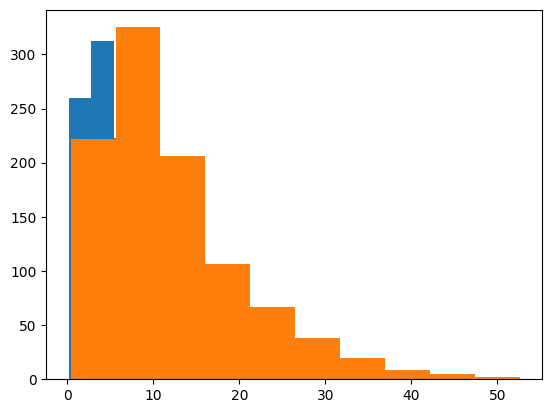

[[2.         0.         3.27319588]
 [2.         0.         9.12621359]]


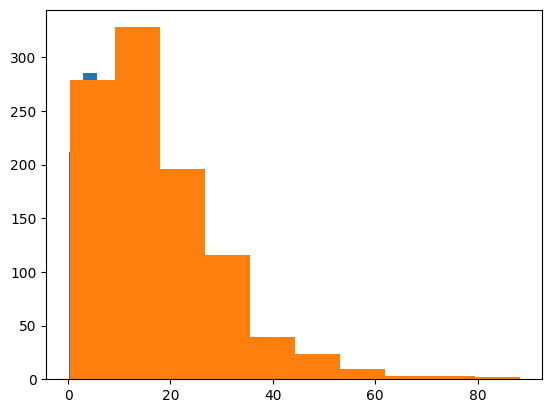

[[2.         0.         1.58762887]
 [2.         0.         2.3592233 ]]


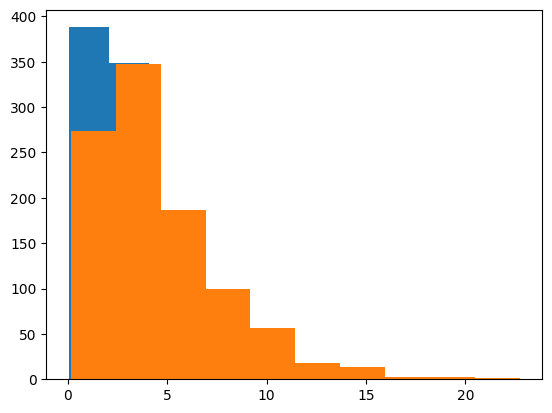

In [14]:
# model.pds holds the Pterms. Pterms.params holds the estimated parameters.
# We can see that the a parameter (params[0]) and the location parameter (params[1])
# remained fixed (like we specified!). The scale parameter (params[2]) changed however
# quite drastically.
# see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.fit.html#scipy.stats.rv_continuous.fit under 'Returns' for details
# on what will be contained in .params for different distributions.
for pdj in model.pds:
    print(pdj.params)
    # We can sample from a Gamma distribution using these parameters
    # to get an estimate of the density.
    sample = scp.stats.gamma.rvs(*pdj.params[0,:],size=1000)
    plt.hist(sample)
    # pd.params[1,:] holds te params for group b.
    sample_b = scp.stats.gamma.rvs(*pdj.params[1,:],size=1000)
    plt.hist(sample_b)
    plt.show()

Evidently, we can expect states 3 and 4 to be more variable in their duration, permitting also for longer stages. The remaining stages are usually shorter. Also, longer stage durations are observable for group b (orange) compared to group a (blue).

## A better random effects structure

When looking through the predictions for some of the series (change s in the cell above) we can notice a drift in some of those series. We could add a random slope over time for every series to account for this. But a simpler model would be to account for subject-specific drift. When we plot all series for individual subjects we can notice that the drift indeed apperas to be specific to subjects and not series.

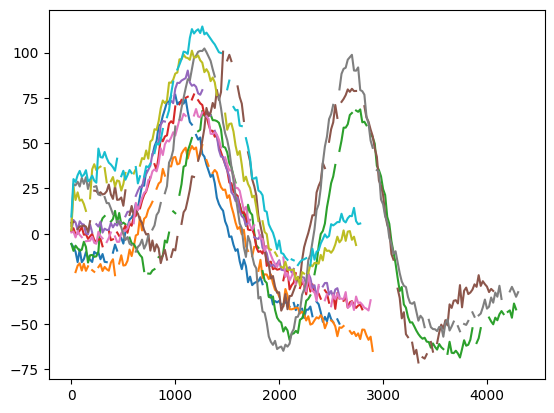

In [15]:
# Subejct-specific drift across series?
for sub in [2]:
    for s in np.unique(dat["series"][dat["sub"] == sub]):
        plt.plot(dat["time"][dat["series"] == s],
                 dat["y"][dat["series"] == s])
    plt.show()


In [16]:
# We can now create a new formula object that features a random slope per subject.
formula2 = Formula(lhs("y"),
                  [irf(["time"],0,nk=15,by="cond",basis_kwargs=[{"max_c":2500,"min_c":0,"convolve":True}]),
                   irf(["time"],1,nk=15,by="cond",basis_kwargs=[{"max_c":2500,"min_c":0,"convolve":True}]),
                   irf(["time"],2,nk=15,by="cond",basis_kwargs=[{"max_c":2500,"min_c":0,"convolve":True}]),
                   irf(["time"],3,nk=15,by="cond",basis_kwargs=[{"max_c":2500,"min_c":0,"convolve":True}]),
                   ri("series"),
                   rs(["time"],rf="sub")], # Random slope per subject
                   data=dat,
                   series_id="series",
                   p_formula=pformula)

# Since we do not make any changes to 'pformula' or fixed we can simply reuse them!
model2 = sMsIRGAMM(formula2,Gaussian(),series_end,fix,cpus=8)

In [17]:
llk_hist2,states_flat2,states2 = model2.fit(t0=0.25,maxiter_outer=10)

Fitting - Conv.: 1.21e+03: 100%|██████████| 10/10 [00:41<00:00,  4.19s/it]


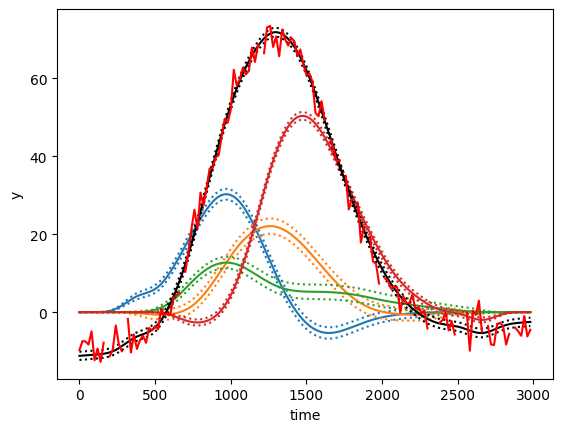

In [18]:
# Now we can make a new prediction - taking the random slope per subject into account!

s = 30 # series to look at

for si in range(4):
    # Set up some new data for prediction
    time_pred = np.arange(0,3000,20)
    new_dat = pd.DataFrame({"time":time_pred,
                            "cond":[np.unique(dat["cond"][dat["series"] == s])[0] for _ in range(len(time_pred))],
                            "sub":[np.unique(dat["sub"][dat["series"] == s])[0] for _ in range(len(time_pred))], # This line is new! We need to take subject into account for the overall prediction.
                            "series":[s for _ in range(len(time_pred))]})
    
    # Make prediction using only individual impulse responses.
    pred,_,b = model2.predict([states2[s]],[si],new_dat,ci=True,alpha=0.05)
    plt.plot(time_pred,pred,color=colors[si])
    plt.plot(time_pred,pred+b,color=colors[si], linestyle='dotted')
    plt.plot(time_pred,pred-b,color=colors[si], linestyle='dotted')

# Additive prediction = sum over all impulse responses = recovered signal.
pred,_,b = model2.predict([states2[s]],None,new_dat,ci=True,alpha=0.05)
plt.plot(time_pred,pred,color='black')
plt.plot(time_pred,pred+b,color='black', linestyle='dotted')
plt.plot(time_pred,pred-b,color='black', linestyle='dotted')

# Plot observed series.
plt.plot(dat["time"][dat["series"] == s],
         dat["y"][dat["series"] == s],color='red')

plt.xlabel("time")
plt.ylabel("y")
plt.show()

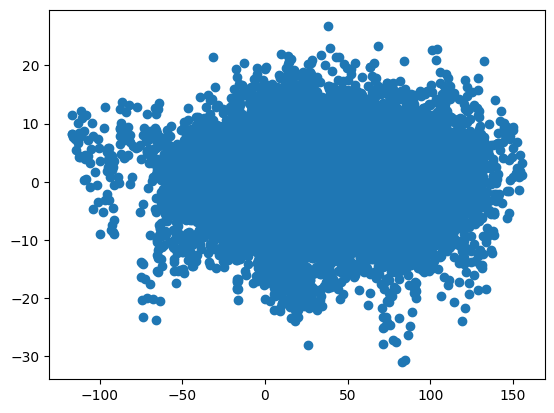

In [19]:
plt.scatter(model2.pred,model2.res)
plt.show()

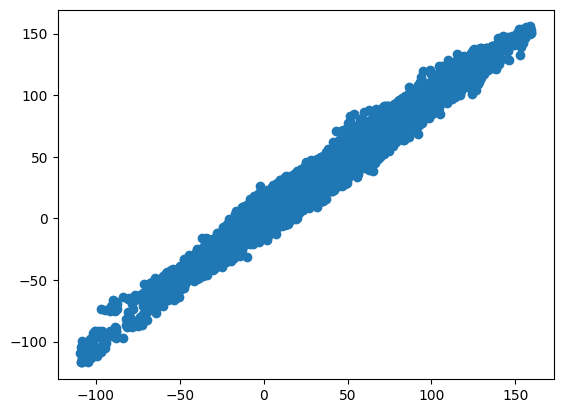

In [20]:
plt.scatter(model2.formula.y_flat[model2.formula.NOT_NA_flat],model2.pred)
plt.show()